In [6]:
from matplotlib import pyplot as plt
import numpy as np

In [7]:
import graph_policy
graph_policy.VARIABLE_NUM = 10

In [8]:
from graph_policy import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnfs, CNF

In [9]:
import tensorflow as tf
import os

BATCH_SIZE = 64

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/activepolicy-18-03-28-122105/model-10000064


In [10]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [11]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [12]:
LEVEL = 10

In [13]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [14]:
np.set_printoptions(precision=3, suppress=True)

In [15]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [16]:
import pycosat

In [17]:
import time
from functools import wraps
def measured(func):
    @wraps(func)
    def new_func(*args, **kwargs):
        start = time.time()
        results = func(*args, **kwargs)
        end = time.time()
        return results, (end - start)
    return new_func

In [18]:
@measured
def solve_graph(cnf: CNF):
    dpll = GraphBasedDPLL()
    res = dpll.run(cnf)
    steps = dpll.number_of_runs
    errors = dpll.number_of_errors
    return res, steps, errors

@measured
def solve_pyco(cnf: CNF):
    return pycosat.solve(cnf.clauses)

In [19]:
from numpy import mean

In [20]:
def get_avg_stats(cnfs):
    times = []
    steps = []
    errors = []
    sat_count = 0
    for cnf in cnfs:
        resp, timp = solve_pyco(cnf)
        if resp == 'UNSAT':
            continue
        (resg, stepg, errg), timg = solve_graph(cnf)
        #print(timp, timg/BATCH_SIZE, 'UNSAT' if resp == 'UNSAT' else 'SAT')
        times.append(timg)
        steps.append(stepg)
        errors.append(errg)
        sat_count += 1
    return mean(times), mean(steps), mean(errors), sat_count

def get_avg_stats_for(var_num, clause_num, sample=100):
    cnfs = get_random_kcnfs(sample, 3, var_num, clause_num, min_clause_number=clause_num)
    return get_avg_stats(cnfs)

In [21]:
def get_avg_stats_for_range(var_nums, clause_nums, sample=5):
    times = []
    steps = []
    errors = []
    sat_counts = []
    for var_num, clause_num in zip(var_nums, clause_nums):
        print("Computing {}, {}, ".format(var_num, clause_num), end="")
        tim, step, error, sat_count = get_avg_stats_for(var_num, clause_num, sample)
        print(tim*sample)
        times.append(tim)
        steps.append(step)
        errors.append(error)
        sat_counts.append(sat_count)
    return times, steps, errors, sat_counts

In [22]:
def plot_avg_stats_for_range(var_nums, clause_nums, sample=5, versus=None):
    times, steps, errors, sat_counts = get_avg_stats_for_range(var_nums, clause_nums, sample)
    plt.title("Times vs {}".format(versus))
    plt.plot(times)
    plt.show()
    plt.title("Steps vs {}".format(versus))
    plt.plot(steps)
    plt.show()
    plt.title("Errors vs {}".format(versus))
    plt.plot(errors)
    plt.show()
    plt.title("Sat count vs {}".format(versus))
    plt.plot(sat_counts)
    plt.show()

Computing 3, 0, 2.5510787963867188e-05
Computing 3, 1, 0.5666162967681885
Computing 3, 2, 0.712033748626709
Computing 3, 3, 1.2883968353271484
Computing 3, 4, 1.5751750469207764
Computing 3, 5, 1.7640984058380127
Computing 3, 6, 2.002379894256592
Computing 3, 7, 1.8151288562350802
Computing 3, 8, 2.1429543495178223
Computing 3, 9, 2.227562189102173
Computing 3, 10, 2.1663148403167725
Computing 3, 11, 2.629568311903212
Computing 3, 12, 2.4729228019714355
Computing 3, 13, 2.5610426494053433
Computing 3, 14, 3.468346118927002
Computing 3, 15, 3.1246867775917053
Computing 3, 16, 3.318814277648926
Computing 3, 17, 2.8763850529988604
Computing 3, 18, 2.7673258781433105
Computing 3, 19, 2.9852179686228437


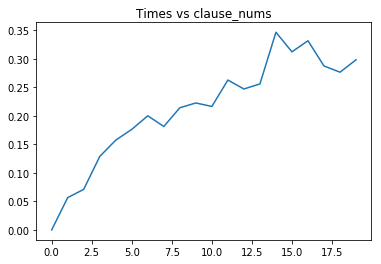

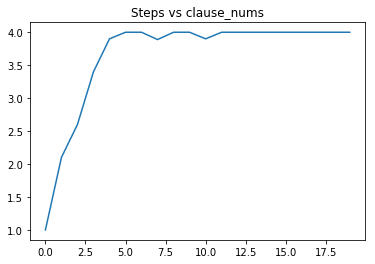

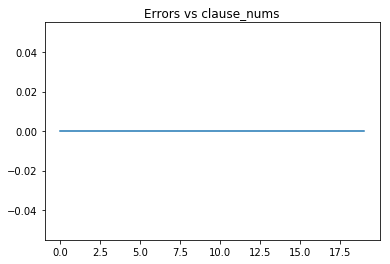

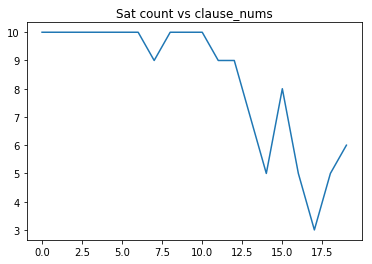

In [87]:
RANGE = 30
plot_avg_stats_for_range([3]*RANGE, range(20), sample=10, versus="clause_nums")

Computing 0, 0, 1.239776611328125e-05
Computing 1, 4, 0.34359604120254517
Computing 2, 8, 0.71539306640625
Computing 3, 12, 1.387925148010254
Computing 4, 16, 1.9123315811157227
Computing 5, 20, 2.5177764892578125
Computing 6, 24, 3.8222146034240723
Computing 7, 28, 5.018969535827637
Computing 8, 32, 6.54069185256958
Computing 9, 36, 7.972281455993652
Computing 10, 40, 8.813507556915283
Computing 11, 44, 10.529140710830688
Computing 12, 48, 13.418090045452118
Computing 13, 52, 17.044635117053986
Computing 14, 56, 17.634423971176147
Computing 15, 60, 21.126140654087067
Computing 16, 64, 24.522056341171265
Computing 17, 68, 26.861650149027504
Computing 18, 72, 29.572278261184692
Computing 19, 76, 33.47570021947225
Computing 20, 80, 38.434173464775085
Computing 21, 84, 38.56432259082794
Computing 22, 88, 43.67170184850693
Computing 23, 92, 572.3987650871277
Computing 24, 96, 54.450410207112625


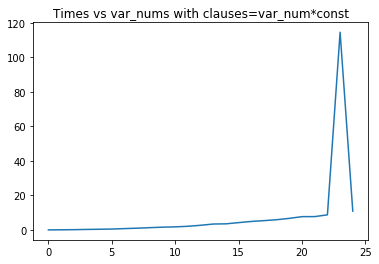

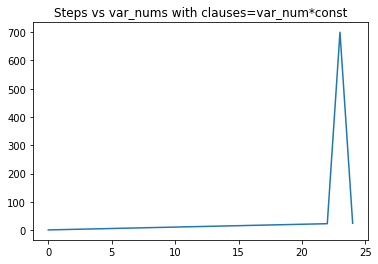

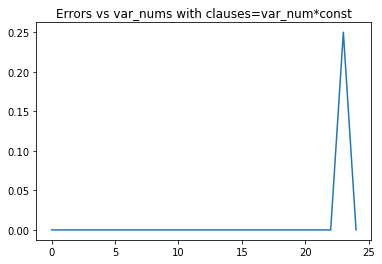

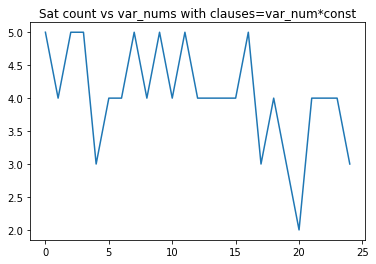

In [89]:
VAR_NUMS = range(25)
CLAUSE_NUMS = [int(var_num*4.0) for var_num in VAR_NUMS]
plot_avg_stats_for_range(VAR_NUMS, CLAUSE_NUMS, sample=5, versus="var_nums with clauses=var_num*const")

Computing 25, 100, 60.568326115608215
Computing 26, 104, 59.874365627765656
Computing 27, 108, 65.53742051124573
Computing 28, 112, 71.57200634479523
Computing 29, 116, 79.09818947315216


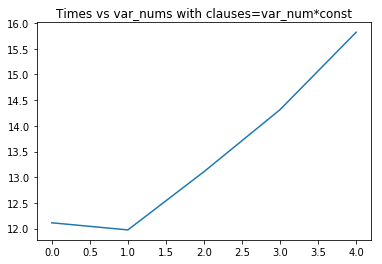

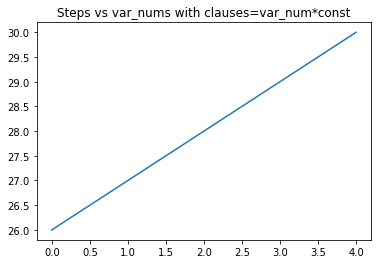

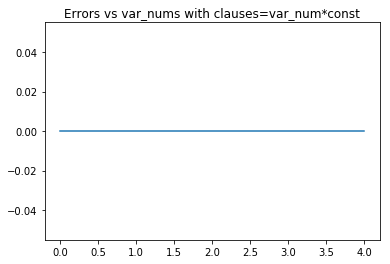

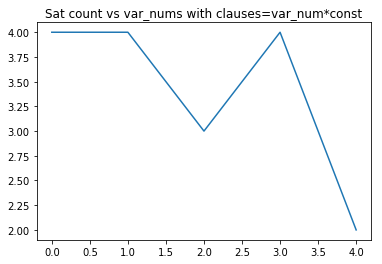

In [23]:
VAR_NUMS = range(25, 30)
CLAUSE_NUMS = [int(var_num*4.0) for var_num in VAR_NUMS]
plot_avg_stats_for_range(VAR_NUMS, CLAUSE_NUMS, sample=5, versus="var_nums with clauses=var_num*const")